##  Exemplo com PDF

In [ ]:
# Importa o Pandas (para usar o DataFrame)
import pandas as pd
# Importa a biblioteca tabula (para ler tabelas de PDF)
import tabula 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sentence_transformers import SentenceTransformer
import chromadb

In [ ]:
# Caminho para o seu arquivo PDF
arquivo_pdf = "CarPrice_Assignment.pdf" # Assumindo que você tem um PDF com as tabelas

# O 'tabula.read_pdf' tenta encontrar tabelas no PDF
# Ele retorna uma LISTA de DataFrames (um para cada tabela encontrada)
lista_de_tabelas_dfs = tabula.read_pdf(arquivo_pdf, pages='all')

# Verificamos se alguma tabela foi encontrada
if lista_de_tabelas_dfs:
    # --- FIM DA MUDANÇA ---
    
    # Assumimos que a primeira tabela (índice 0) é a que queremos
    df = lista_de_tabelas_dfs[0] 
    print("Tabela do PDF carregada com sucesso!")
    
    # --- A PARTIR DAQUI, TUDO É IDÊNTICO AO OUTRO NOTEBOOK ---

In [2]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')

#### 📌 Explicação:
Convertendo as colunas price e horsepower para tipo numérico. Isso evita erros nas análises que envolvem cálculo ou correlação. O parâmetro errors='coerce' transforma valores inválidos em NaN(Not a number).

### 💡 Etapa 3 – Inspeção dos Dados

In [3]:
print("Formato:", df.shape)
print(df.dtypes)
print(df.isnull().sum())

df.describe()

df.describe(include='O')

Formato: (205, 26)
car_ID                int64
symboling             int64
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
dtype: object
car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength          

,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem
count,205,205,205,205,205,205,205,205,205,205
unique,147,2,2,2,5,3,2,7,7,8
top,peugeot 504,gas,std,four,sedan,fwd,front,ohc,four,mpfi
freq,6,185,168,115,96,120,202,148,159,94


####  📌 Explicação:

- `df.shape`: retorna número de linhas e colunas.

- `df.dtypes`: mostra o tipo de cada coluna.

- `df.isnull().sum()`: verifica colunas com valores nulos.

- `df.describe()`: mostra estatísticas descritivas das variáveis numéricas (média, desvio, mínimo, máximo, etc.).

### 💡 Etapa 4 – Heatmap de Correlação

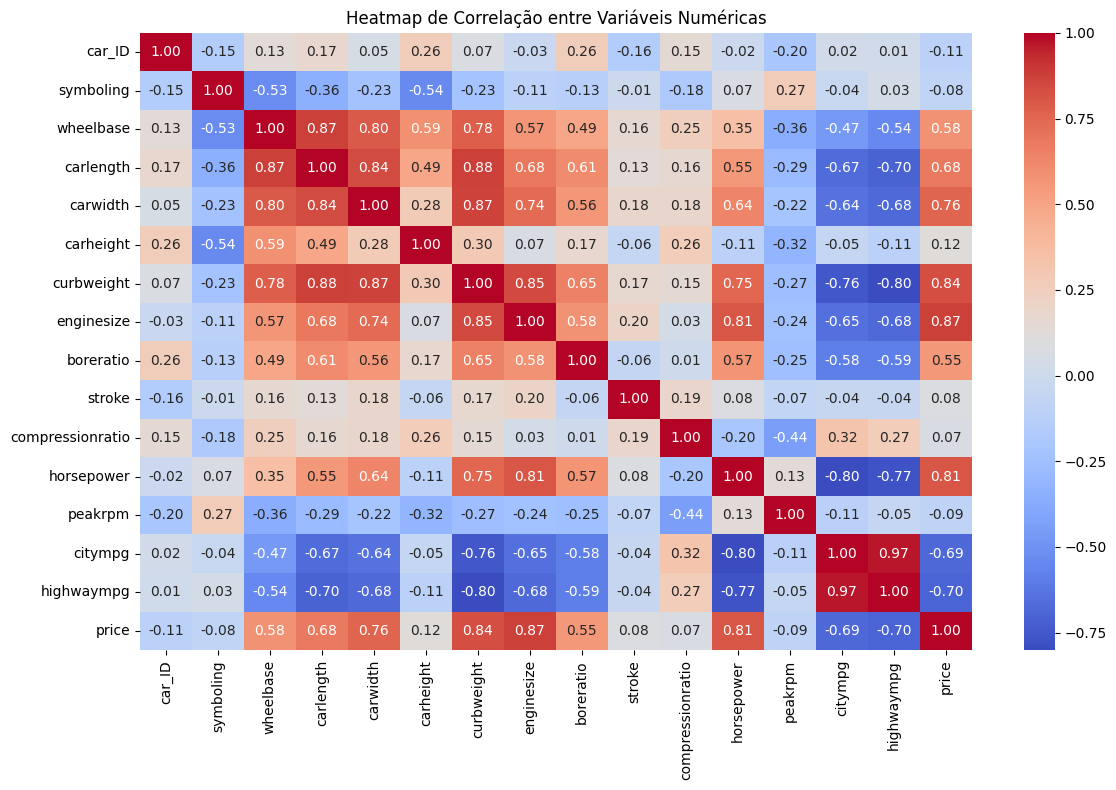

In [4]:
correlation = df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap de Correlação entre Variáveis Numéricas")
plt.tight_layout()
plt.show()

#### 📌 Explicação:

Criamos um heatmap para analisar a correlação entre colunas numéricas.

- `annot=True`: mostra os valores numéricos nas células.

- `cmap='coolwarm'`: define o gradiente de cores.

- `fmt=".2f"`: formata os números com duas casas decimais.

🤔 **Insight:** Alta correlação entre `enginesize`, `curbweight`, `horsepowe`r e `price`.

### 💡 Etapa 5 – Boxplot por Tipo de Carroceria (`carbody`)

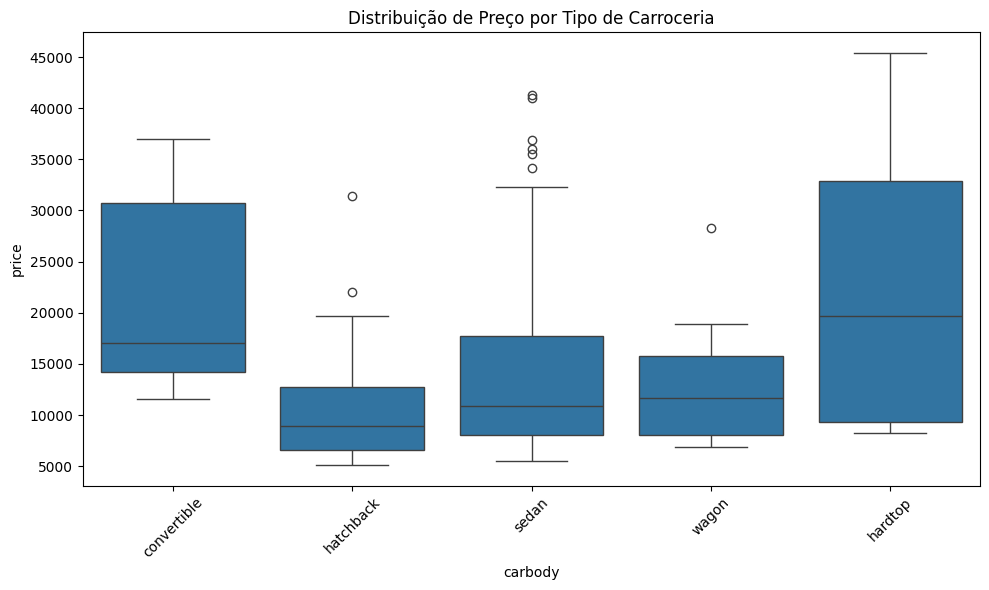

In [5]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="carbody", y="price")
plt.title("Distribuição de Preço por Tipo de Carroceria")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 📌 Explicação:

O boxplot mostra a distribuição de preços por tipo de carro.

- `x="carbody"` define a variável categórica (tipo de carroceria).

- `y="price"` define a variável numérica.

- O gráfico ajuda a identificar mediana, dispersão e outliers em cada grupo.

🤔 **Insight:** Convertibles tendem a ter maior preço; hatchbacks mostram grande variabilidade.

### 💡 Etapa 6 – Criação de Descrições Textuais (Chunks)

Criar uma representação textual de cada carro para que possa ser vetorizada e utilizada em busca semântica.

In [6]:
# Define uma função que recebe uma linha (row) do DataFrame e retorna um texto descritivo baseado nas colunas
def gerar_descricao(row):
    return (
        f"{row['CarName']}, {row['carbody']} com motor de {row['enginesize']}cc, "
        f"alimentado por {row['fueltype']} com aspiração {row['aspiration']}, "
        f"{row['doornumber']} portas, tração {row['drivewheel']}, "
        f"{row['horsepower']} HP, consumo urbano de {row['citympg']} MPG "
        f"e preço aproximado de ${row['price']:.2f}."
    )

# Aplica essa função a cada linha do DataFrame, criando uma nova coluna com os textos descritivos
df["descricao_textual"] = df.apply(gerar_descricao, axis=1)

#### 📌 Explicação:

### 💡 Etapa 7 – Embedding dos Textos

Temos que converter os textos em vetores numéricos usando um modelo de embeddings (aqui, usaremos o SentenceTransformer do HuggingFace).

In [7]:
from sentence_transformers import SentenceTransformer

# Carrega o modelo de embedding (pode usar um leve como 'all-MiniLM-L6-v2')
modelo = SentenceTransformer('all-MiniLM-L6-v2')

# Gera os embeddings para cada descrição
embeddings = modelo.encode(df["descricao_textual"].tolist())

d:\RepositoriosGit\Inteligencia-Artificial\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 📌 Explicação:

- `SentenceTransformer` converte cada texto em um vetor de alta dimensão.

- O modelo `all-MiniLM-L6-v2` é pequeno, eficiente e funciona bem para tarefas de busca semântica.

### 💡 Etapa 8 – Armazenamento no ChromaDB

Salvar os vetores em um Banco de Dados Vetorial (ChromaDB), que permite buscas por similaridade.

In [8]:
# Importa a biblioteca ChromaDB, um banco de dados vetorial usado para armazenar vetores (embeddings)
import chromadb

# Inicializa o cliente do ChromaDB em modo in-memory (sem persistência em disco)
# Ideal para experimentos, provas e ambientes temporários
client = chromadb.Client()

# Cria uma nova coleção chamada "carros_autosmart"
# Essa coleção é como uma tabela onde vamos guardar os textos (documentos) e seus embeddings
collection = client.create_collection(name="carros_autosmart")

# Adiciona os documentos na coleção:
collection.add(
    # Lista de textos descritivos (um para cada carro), extraídos da coluna 'descricao_textual'
    documents=df["descricao_textual"].tolist(),

    # Lista de embeddings (vetores) correspondentes a cada descrição textual
    embeddings=embeddings,

    # Lista de IDs únicos para identificar cada carro na base vetorial
    # Aqui usamos um padrão 'carro_0', 'carro_1', ..., baseado no índice do DataFrame
    ids=[f"carro_{i}" for i in df.index]
)


#### 📌 Explicação:

`create_collection`: cria uma nova "tabela vetorial".

`add`: adiciona os textos, vetores (embeddings) e IDs únicos.

 - Esses dados estão agora prontos para busca semântica por similaridade!

#### 🧠 Resumo Conceitual
Esse trecho de código realiza 3 ações principais:

1. Cria um banco de dados vetorial na memória
2. Define uma "coleção" (tabela vetorial) para armazenar os dados
3. Armazena descrições em linguagem natural e seus vetores correspondentes

#### 📦 O que é armazenado?
Cada registro vetorial contém:

- `ID`: ex. "`carro_57`"
- `Document`: ex. "audi 100ls, sedan com motor de 136cc..."
- `Embedding`: um vetor de alta dimensão (ex: 384 ou 768 valores)

Esse conjunto pode ser usado posteriormente para buscas por similaridade semântica.

### 💡 Etapa 9 – Busca Semântica com ChromaDB

Buscar os k carros mais similares a uma pergunta natural.

In [9]:
consulta = "Quais carros são econômicos e baratos?"
embedding_consulta = modelo.encode([consulta])

resultado = collection.query(
    query_embeddings=embedding_consulta,
    n_results=5
)

for doc in resultado['documents'][0]:
    print("- " + doc)

- mitsubishi montero, sedan com motor de 122cc, alimentado por gas com aspiração std, four portas, tração fwd, 88 HP, consumo urbano de 25 MPG e preço aproximado de $6989.00.
- subaru, sedan com motor de 108cc, alimentado por gas com aspiração std, four portas, tração fwd, 82 HP, consumo urbano de 32 MPG e preço aproximado de $7126.00.
- nissan latio, sedan com motor de 97cc, alimentado por gas com aspiração std, four portas, tração fwd, 69 HP, consumo urbano de 31 MPG e preço aproximado de $6849.00.
- subaru baja, sedan com motor de 108cc, alimentado por gas com aspiração std, four portas, tração fwd, 94 HP, consumo urbano de 26 MPG e preço aproximado de $9960.00.
- nissan latio, sedan com motor de 97cc, alimentado por gas com aspiração std, four portas, tração fwd, 69 HP, consumo urbano de 31 MPG e preço aproximado de $7499.00.


#### 📌 Explicação:

- A pergunta é embutida em vetor com o mesmo modelo.

- `query()` retorna os 5 documentos mais similares.

- A busca é feita por distância vetorial (ex: cosseno).